In [84]:
import json
from pathlib import Path
import matplotlib as mpl
import tikzplotlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rich.progress import track
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, f1_score
from sklearn.preprocessing import MaxAbsScaler

In [89]:
def parse_files(root_path):
    """
    Parse files and use pd.json_normalize to flatten the json.
    """
    files = root_path.joinpath("train-output-all-features").glob("**/*.json")
    results = pd.DataFrame()
    files = list(files)

    for file in track(
        files,
        description="Loading hyperparameters and "
        "performance data from file to DataFrame",
    ):
        with open(file) as f:
            data = json.load(f)
            original_target = root_path.joinpath(data["original_target"])
            original_dict = json.loads(Path(original_target).read_text())

            f1_scores = pd.json_normalize(data, "f1_scores")
            normalized_data = pd.json_normalize(original_dict)
            normalized_data = pd.concat(
                [normalized_data] * len(f1_scores), ignore_index=True
            )
            normalized_data["metrics.f1_score"] = f1_scores
            normalized_data["paths.model_path"] = data["model_path"]
            results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

    results = results.set_index(
        ["percentage", "model", "use_gradient", "use_ewma"]
    )
    results.columns = pd.MultiIndex.from_arrays(
        zip(*results.columns.str.split(".", expand=True))
    )
    results = results.sort_index(axis=1)
    results = results.drop(columns=['k_fold', 'preprocessing'])
    results = results.droplevel(0, axis=1)

    return results


data_flattened = parse_files(Path("./analysis/"))
data_flattened

Output()

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

/var/folders/7t/k8q3439j6z3c683j7w00wtm80000gn/T/ipykernel_58430/330735155.py:26: FutureWarning: The behavior of 
DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer 
exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the 
relevant entries before the concat operation.
  results = pd.concat([results, normalized_data]) #.dropna(axis=1, how="all")])

C  alpha hidden_layer_sizes kernel  \
percentage model use_gradient use_ewma                                         
4          SVM   True         False     1.0    NaN                NaN    rbf   
                              False     1.0    NaN                NaN    rbf   
                              False     1.0    NaN                NaN    rbf   
                              False     1.0    NaN                NaN    rbf   
                              False     1.0    NaN                NaN    rbf   
...                                     ...    ...                ...    ...   
19         LR    False        False     1.0    NaN                NaN    NaN   
                              False     1.0    NaN                NaN    NaN   
                              False     1.0    NaN                NaN    NaN   
                              False     1.0    NaN                NaN    NaN   
                              False     1.0    NaN                NaN    NaN   

                                        learning_rate  max_depth  \
percentage model use_gradient use_ewma                             
4          SVM   True         False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
...                                               ...        ...   
19         LR    False        False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   

                                        n_estimators  f1_score  \
percentage model use_gradient use_ewma                           
4          SVM   True         False              NaN  0.715789   
                              False              NaN  0.702128   
                              False              NaN  0.701031   
                              False              NaN  0.747475   
                              False              NaN  0.744681   
...                                              ...       ...   
19         LR    False        False              NaN  0.619048   
                              False              NaN  0.488889   
                              False              NaN  0.465116   
                              False              NaN  0.478261   
                              False              NaN  0.510638   

                                                                               model_path  
percentage model use_gradient use_ewma                                                     
4          SVM   True         False     train-output-all-features/SVM_4_grad_no-ewma_3...  
                              False     train-output-all-features/SVM_4_grad_no-ewma_3...  
                              False     train-output-all-features/SVM_4_grad_no-ewma_3...  
                              False     train-output-all-features/SVM_4_grad_no-ewma_3...  
                              False     train-output-all-features/SVM_4_grad_no-ewma_3...  
...                                                                                   ...  
19         LR    False        False     train-output-all-features/LR_19_no-grad_no-ewm...  
                              False     train-output-all-features/LR_19_no-grad_no-ewm...  
                              False     train-output-all-features/LR_19_no-grad_no-ewm...  
                              False     train-output-all-features/LR_19_no-grad_no-ewm...  
                              False     train-output-all-features/LR_19_no-grad_no-ewm...  

[33540 rows x 9 columns]

In [90]:
# Remove any runs that included use_ewma or use_gradient
df = data_flattened.loc[(slice(None), slice(None), False, False), :]
df.index = df.index.droplevel([2, 3])
df = df.sort_values(by=['percentage', 'model'])
df

C  alpha hidden_layer_sizes  kernel  learning_rate  \
percentage model                                                            
1          AdaBoost  NaN    NaN                NaN     NaN            0.1   
           AdaBoost  NaN    NaN                NaN     NaN            0.1   
           AdaBoost  NaN    NaN                NaN     NaN            0.1   
           AdaBoost  NaN    NaN                NaN     NaN            0.1   
           AdaBoost  NaN    NaN                NaN     NaN            0.1   
...                  ...    ...                ...     ...            ...   
20         SVM       0.1    NaN                NaN  linear            NaN   
           SVM       0.1    NaN                NaN  linear            NaN   
           SVM       0.1    NaN                NaN  linear            NaN   
           SVM       0.1    NaN                NaN  linear            NaN   
           SVM       0.1    NaN                NaN  linear            NaN   

                     max_depth  n_estimators  f1_score  \
percentage model                                         
1          AdaBoost        NaN          50.0  0.790323   
           AdaBoost        NaN          50.0  0.760331   
           AdaBoost        NaN          50.0  0.740157   
           AdaBoost        NaN          50.0  0.789474   
           AdaBoost        NaN          50.0  0.777778   
...                        ...           ...       ...   
20         SVM             NaN           NaN  0.380952   
           SVM             NaN           NaN  0.491228   
           SVM             NaN           NaN  0.416667   
           SVM             NaN           NaN  0.604651   
           SVM             NaN           NaN  0.500000   

                                                            model_path  
percentage model                                                        
1          AdaBoost  train-output-all-features/AdaBoost_1_no-grad_n...  
           AdaBoost  train-output-all-features/AdaBoost_1_no-grad_n...  
           AdaBoost  train-output-all-features/AdaBoost_1_no-grad_n...  
           AdaBoost  train-output-all-features/AdaBoost_1_no-grad_n...  
           AdaBoost  train-output-all-features/AdaBoost_1_no-grad_n...  
...                                                                ...  
20         SVM       train-output-all-features/SVM_20_no-grad_no-ew...  
           SVM       train-output-all-features/SVM_20_no-grad_no-ew...  
           SVM       train-output-all-features/SVM_20_no-grad_no-ew...  
           SVM       train-output-all-features/SVM_20_no-grad_no-ew...  
           SVM       train-output-all-features/SVM_20_no-grad_no-ew...  

[8600 rows x 9 columns]

In [91]:
def float_or_list_to_tuple(x):
    if isinstance(x, list):
        return tuple(x)
    return x

df["hidden_layer_sizes"] = df['hidden_layer_sizes'].apply(float_or_list_to_tuple)

In [92]:
group = df.groupby(['percentage', 'model', 'C', 'hidden_layer_sizes', 'kernel', 'learning_rate', 'max_depth', 'n_estimators', 'alpha'], dropna=False)
summary = group['f1_score'].agg(['mean', 'std'])

idx = summary.groupby(['percentage', 'model']).idxmax()

best_hyperparams = summary.loc[idx['mean'], :]
best_per_percentage = best_hyperparams.groupby('percentage')['mean'].idxmax()
selected_percentages = best_hyperparams[best_hyperparams.index.get_level_values('percentage').isin([5, 10, 15, 20]) & best_hyperparams.index.get_level_values('model').isin(['RF', 'ET'])]
models_to_test = selected_percentages.droplevel(['C', 'hidden_layer_sizes', 'kernel', 'learning_rate', 'alpha'])
models_to_test


mean       std
percentage model max_depth n_estimators                    
5          ET    NaN       200.0         0.849900  0.033471
           RF    NaN       100.0         0.847879  0.035680
10         ET    20.0      50.0          0.789458  0.050348
           RF    20.0      200.0         0.805133  0.036164
15         ET    20.0      100.0         0.747298  0.099952
           RF    10.0      200.0         0.741128  0.068748
20         ET    20.0      200.0         0.707496  0.099268
           RF    10.0      100.0         0.704397  0.092276

In [93]:
print(models_to_test.droplevel(['max_depth', 'n_estimators']).round(3).to_latex(float_format="%.3f"))

\begin{tabular}{llrr}
\toprule
 &  & mean & std \\
percentage & model &  &  \\
\midrule
\multirow[t]{2}{*}{5} & ET & 0.850 & 0.033 \\
 & RF & 0.848 & 0.036 \\
\cline{1-4}
\multirow[t]{2}{*}{10} & ET & 0.789 & 0.050 \\
 & RF & 0.805 & 0.036 \\
\cline{1-4}
\multirow[t]{2}{*}{15} & ET & 0.747 & 0.100 \\
 & RF & 0.741 & 0.069 \\
\cline{1-4}
\multirow[t]{2}{*}{20} & ET & 0.707 & 0.099 \\
 & RF & 0.704 & 0.092 \\
\cline{1-4}
\bottomrule
\end{tabular}



In [94]:
random_state = 42
classifiers = {}
for percentage, model, max_depth, n_estimators in models_to_test.index:
    if np.isnan(max_depth):
        max_depth = None
    else:
        max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    if model == 'ET':
        classifiers[(percentage, model)] = ExtraTreesClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=random_state, class_weight='balanced')
    elif model == 'RF':
        classifiers[(percentage, model)] = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=random_state, class_weight='balanced_subsample')
classifiers

{(5,
  'ET'): ExtraTreesClassifier(class_weight='balanced', n_estimators=200, random_state=42),
 (5,
  'RF'): RandomForestClassifier(class_weight='balanced_subsample', random_state=42),
 (10,
  'ET'): ExtraTreesClassifier(class_weight='balanced', max_depth=20, n_estimators=50,
                      random_state=42),
 (10,
  'RF'): RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                        n_estimators=200, random_state=42),
 (15,
  'ET'): ExtraTreesClassifier(class_weight='balanced', max_depth=20, random_state=42),
 (15,
  'RF'): RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                        n_estimators=200, random_state=42),
 (20,
  'ET'): ExtraTreesClassifier(class_weight='balanced', max_depth=20, n_estimators=200,
                      random_state=42),
 (20,
  'RF'): RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                        random_state=42)}

In [96]:
import pickle

def preprocess(dataframe):
    result, mzn = dataframe.drop(columns=['mzn', 'dzn'], axis=1), dataframe['mzn']

    # Drop any columns that contain the text 'ewma' or 'gradient'
    result = result.drop(columns=result.columns[result.columns.str.contains('ewma|gradient')], axis=1)

    result = result.drop(result.columns[result.nunique() == 1], axis=1)

    transformer = MaxAbsScaler().fit(result)
    result = pd.DataFrame(transformer.transform(result), columns=result.columns, index=result.index)

    result['mzn'] = mzn

    return result

train_pkl = Path('./analysis/rerun_with_all_features_train.pkl')

with open(train_pkl, 'rb') as f:
    train_features_at_percentage = pickle.load(f)

for perc in train_features_at_percentage:
    train_features_at_percentage[perc] = train_features_at_percentage[perc]

for percentage, model in classifiers:
    print(f"Training {model} at {percentage}%")
    df: pd.DataFrame = preprocess(train_features_at_percentage[percentage])
    df = df.drop(columns=['mzn'], axis=1)
    any_nan = df.isna().any().any()
    which_nan = df.isna().any(axis=1)
    if any_nan:
        print("The NaN values are in the following columns:")
        print(df.columns[df.isna().any()])
    else:
        train_X, train_y = df.drop(columns=['solved_within_time_limit']), df['solved_within_time_limit']
        classifiers[(percentage, model)].fit(train_X, train_y)



Training ET at 5%
Training RF at 5%
Training ET at 10%
Training RF at 10%
Training ET at 15%
Training RF at 15%
Training ET at 20%
Training RF at 20%


In [9]:
train_features_at_percentage[5].columns

Index(['conflicts', 'ewma_conflicts', 'decisions', 'search_iterations',
       'opennodes', 'ewma_opennodes', 'vars', 'back_jumps', 'ewma_back_jumps',
       'solutions', 'total_time', 'search_time', 'intVars', 'propagations',
       'sat_propagations', 'ewma_propagations', 'propagators', 'boolVars',
       'learnt', 'bin', 'tern', 'long', 'peak_depth', 'decision_level_engine',
       'ewma_decision_level_engine', 'decision_level_treesize', 'clause_mem',
       'prop_mem', 'fracFailUnassn', 'fracOpenVisit', 'fracBoolVars',
       'fracPropVars', 'frac_unassigned', 'fracLongClauses', 'freqBackjumps',
       'mzn', 'dzn', 'solved_within_time_limit', 'conflicts_gradient',
       'ewma_conflicts_gradient', 'decisions_gradient',
       'search_iterations_gradient', 'opennodes_gradient',
       'ewma_opennodes_gradient', 'vars_gradient', 'back_jumps_gradient',
       'ewma_back_jumps_gradient', 'solutions_gradient', 'total_time_gradient',
       'intVars_gradient', 'search_time_gradient', 'p

In [10]:
train_features_at_percentage[1]

,conflicts,ewma_conflicts,decisions,search_iterations,opennodes,ewma_opennodes,vars,back_jumps,ewma_back_jumps,solutions,...,fracOpenVisit,fracBoolVars,fracPropVars,frac_unassigned,fracLongClauses,freqBackjumps,mzn,dzn,solved_within_time_limit,has_gradients
1171,8803,8784.0,11197,20001,3088703,3088703.50,3090204,891,0.05,0,...,0.000486,0.833344,3.691990,1.0,0,24.717299,2DPacking.mzn,Class7_100_8.dzn,False,False
638,91874,91855.0,110223,201798,1703,1703.31,1715,18246,0.12,3,...,0.007046,0.923615,2948.814577,1.0,441,506.925397,still_life_free.mzn,7x7.dzn,True,False
931,11623,11604.0,192877,204501,169010,169015.28,169028,181234,21.00,0,...,0.000107,0.996036,24.709220,1.0,3597,5033.713722,wwtpp.mzn,ex05200_2600_100.dzn,True,False
258,78777,78758.0,81520,20,75046,75011.64,75053,13,0.00,303,...,0.000093,0.998867,242.995110,1.0,0,0.360887,city-position.mzn,city-5-06.dzn,False,False
1182,37362,37343.0,98212,9372,37725,37725.63,37734,59721,0.00,26,...,0.000239,0.945540,2057.901654,1.0,8886,1660.024595,ProjectPlannertest_16_7.mzn,NO-MODEL-FILE.dzn,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173,1402,1383.0,4082,584,6738231,6738223.50,6738283,1594,0.02,16,...,0.000008,0.999954,0.024360,1.0,7387335,44.230549,group.mzn,u15g3pref2.dzn,False,False
714,100714,100695.0,111385,212100,25323,25324.05,25332,10663,0.00,0,...,0.000355,0.982670,213.748026,1.0,1555,296.139971,mrcpsp.mzn,j30_6_8.dzn,True,False
699,89041,89022.0,91142,76988,19205,19205.36,19214,1665,0.00,17,...,0.000469,0.996513,162.669304,1.0,4698,46.257337,depot_placement.mzn,ulysses22_6.dzn,True,False
900,49573,49554.0,56626,105054,19979,19979.86,20000,6473,0.15,1,...,0.001051,0.833550,1626.776600,1.0,0,179.778898,wachplan.mzn,NO-MODEL-FILE.dzn,True,False


Testing ET at 5%
F1 score for ET at 5%: 0.21276595744680848
Testing RF at 5%
F1 score for RF at 5%: 0.6875000000000001
Testing ET at 10%
F1 score for ET at 10%: 0.1212121212121212
Testing RF at 10%
F1 score for RF at 10%: 0.06666666666666667
Testing ET at 15%
F1 score for ET at 15%: 0.23076923076923078
Testing RF at 15%
F1 score for RF at 15%: 0.41379310344827586
Testing ET at 20%
F1 score for ET at 20%: 0.32
Testing RF at 20%
F1 score for RF at 20%: 0.1


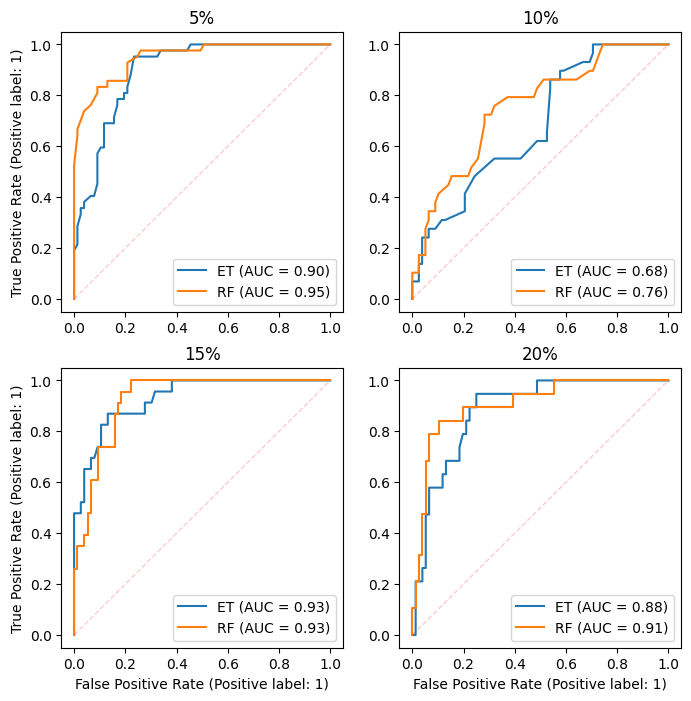

In [97]:
test_pickle = Path('./analysis/rerun_with_all_features_test.pkl')

with open(test_pickle, 'rb') as f:
    test_features_at_percentage = pickle.load(f)

for perc in test_features_at_percentage:
    test_features_at_percentage[perc] = test_features_at_percentage[perc]

plots = {}
# Create a figure and axes with 4 subplots
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
# ax = plt.gca()
scores = []

for i, percentage in enumerate([5, 10, 15, 20]):
    for model in ['ET', 'RF']:
        print(f"Testing {model} at {percentage}%")
        df: pd.DataFrame = preprocess(test_features_at_percentage[percentage])
        df = df.drop(columns=['mzn'], axis=1)
        
        test_X, test_y = df.drop(columns=['solved_within_time_limit']), df['solved_within_time_limit']
        
        y_score = classifiers[(percentage, model)].predict_proba(test_X)[:, 1]
        plots[(percentage, model)] = RocCurveDisplay.from_predictions(test_y, y_score, ax=ax[i], name=model)
        score = f1_score(test_y, classifiers[(percentage, model)].predict(test_X))
        print(f"F1 score for {model} at {percentage}%: {score}")
        scores.append([percentage, model, score])
        if percentage in [5, 10]:
            ax[i].set_xlabel('')
        if percentage in [10, 20]:
            ax[i].set_ylabel('')
    ax[i].set_title(f"{percentage}%")
    ax[i].plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', alpha=.2)

tikzplotlib.clean_figure()
tikzplotlib.save("roc_curves.tex", axis_width="0.6\\textwidth", axis_height="0.6\\textwidth")

In [100]:
print(pd.DataFrame(scores, columns=['Percentage', 'Model', 'F1 score']).set_index(['Percentage', 'Model']).round(3).to_latex(float_format="%.3f", sparsify=True))

\begin{tabular}{llr}
\toprule
 &  & F1 score \\
Percentage & Model &  \\
\midrule
\multirow[t]{2}{*}{5} & ET & 0.213 \\
 & RF & 0.688 \\
\cline{1-3}
\multirow[t]{2}{*}{10} & ET & 0.121 \\
 & RF & 0.067 \\
\cline{1-3}
\multirow[t]{2}{*}{15} & ET & 0.231 \\
 & RF & 0.414 \\
\cline{1-3}
\multirow[t]{2}{*}{20} & ET & 0.320 \\
 & RF & 0.100 \\
\cline{1-3}
\bottomrule
\end{tabular}



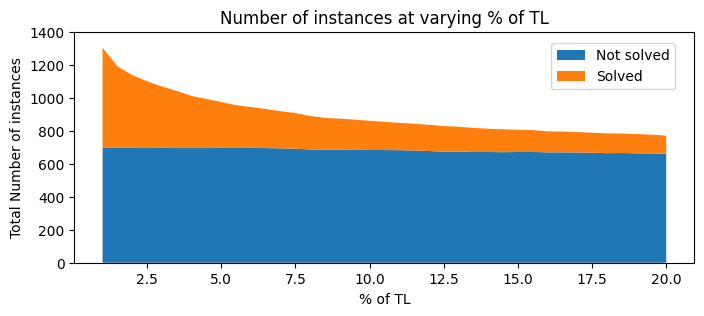

In [37]:
n_total = np.array([train_features_at_percentage[i].shape[0] for i in range(1, len(train_features_at_percentage) + 1)])
n_solved = np.array([train_features_at_percentage[i]['solved_within_time_limit'].sum() for i in range(1, len(train_features_at_percentage) + 1)])
n_not_solved = np.array([n_total[i] - n_solved[i] for i in range(len(n_total))])
percentage_solved = np.array([n_solved[i] / n_total[i] for i in range(len(n_total))]) * 100

x = np.arange(1, 20.5, 0.5)

fig, ax = plt.subplots(figsize=(8, 3))
stacks = ax.stackplot(x, n_not_solved, n_solved, labels=['Not solved', 'Solved'])
ax.set_title("Number of instances at varying % of TL")
ax.set_xlabel("% of TL")
ax.set_ylabel("Total Number of instances")
ax.set_ylim([0, 1400])
ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98))

# fig.legend(loc='upper right', bbox_to_anchor=(0.88, 0.88))
# fig.tight_layout()
# plt.savefig("class_balance_over_time.pgf", backend="pgf")
# tikzplotlib.clean_figure()
tikzplotlib.save("class_balance_over_time.tex", axis_width="0.9\\textwidth", axis_height="0.4\\textwidth")